# Rib Fracture (Logistic Regression)

* Predict rib fracture from several features taken 

In [18]:
import pandas as pd
import pystan

In [19]:
rsf = pd.read_csv('../data/ribstressfractures.csv')

In [20]:
# Other types of imputations could be done here
rsf = rsf.dropna()

In [21]:
# The features to try and predict rib
rsf.head()

,ID,Age,FemaleMale,SweepScull,HeavyLight,RibBMD,SpineBMD,HipBMD,BodyFat,BinResp,AgeGp
0,1,23,1,0,1,0.724,1.298,1.044,13.2,0,0
1,2,20,0,1,0,0.737,1.259,1.082,13.1,0,0
2,3,30,0,1,0,0.692,1.331,1.094,6.6,0,1
3,4,25,0,0,1,0.868,1.665,1.580,10.8,0,0
4,5,23,1,1,1,0.783,1.384,1.046,25.7,0,0


# Model

* This is not a proper complete logistic regression as more interaction features could be added to use the full power of the model. But here we use each individual feature alone.

In [22]:
model = """
data {
    int N;
    real Age[N];
    real BodyFat[N];
    real HipBMD[N];
    real SpineBMD[N];
    real RibBMD[N];
    int HeavyLight[N];
    int SweepScull[N];
    int AgeGp[N];
    int FemaleMale[N];
    int BinResp[N];
}
parameters {
    real a[10];
}
model {
    for (i in 1:N) {
        BinResp[i] ~ bernoulli_logit(a[1] * Age[i]        + a[2] * BodyFat[i]    + a[3] * HipBMD[i]     +
                                     a[4] * SpineBMD[i]   + a[5] * RibBMD[i]     + a[6] * HeavyLight[i] +
                                     a[7] * SweepScull[i] + a[8] * AgeGp[i]      + a[9] * FemaleMale[i] +
                                     a[10]);
    }
    
    for (i in 1:10) {
        a[i] ~ normal(0, 20);
    }
}
"""

In [23]:
%%time

sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b17b577d59fca7966fadcda5421aef01 NOW.


CPU times: user 1.1 s, sys: 52.1 ms, total: 1.15 s
Wall time: 1min 2s


In [35]:
%%time

struct_data = {
    'N': len(rsf),
    'Age': rsf['Age'].values,
    'BodyFat': rsf['BodyFat'].values,
    'HipBMD': rsf['HipBMD'].values,
    'SpineBMD': rsf['SpineBMD'].values,
    'FemaleMale': rsf['FemaleMale'].values,
    'RibBMD': rsf['RibBMD'].values,
    'HeavyLight': rsf['HeavyLight'].values,
    'SweepScull': rsf['SweepScull'].values,
    'AgeGp': rsf['AgeGp'].values,
    'BinResp': rsf['BinResp'].values
}
fit = sm.sampling(data=struct_data, iter=1000, chains=2)

/home/nawarhalabi/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


CPU times: user 21.8 ms, sys: 32.3 ms, total: 54.2 ms
Wall time: 9.9 s


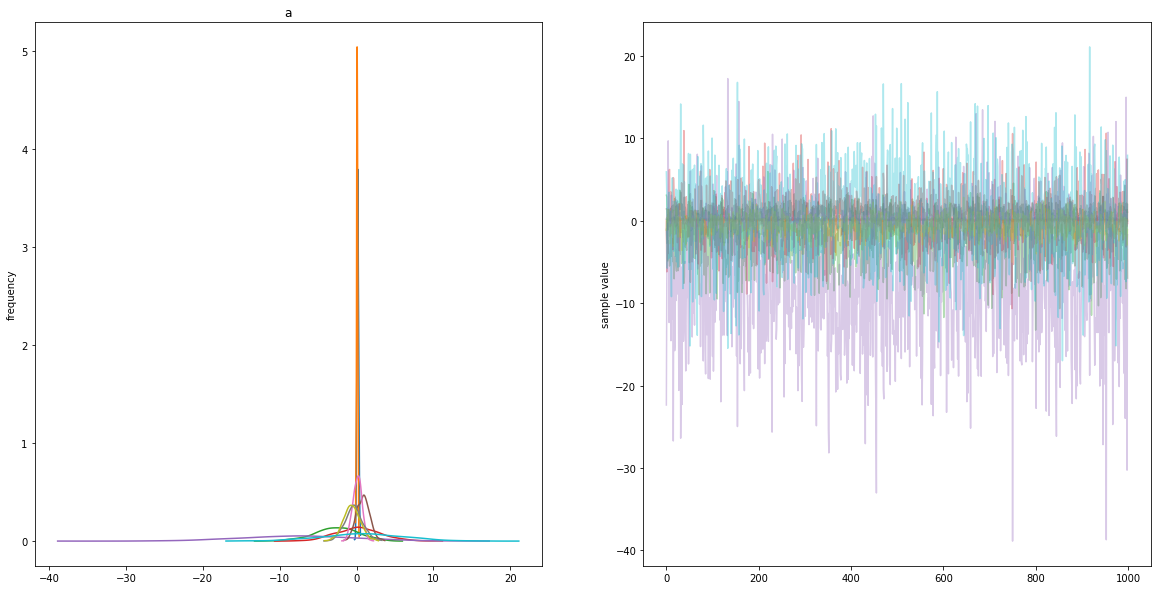

In [36]:
f = fit.plot()
f.set_size_inches(20, 10)

# Results

* Notice the means nad the se_means to compare how relevant each feature is to the predictor.

In [37]:
fit

Inference for Stan model: anon_model_b17b577d59fca7966fadcda5421aef01.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[0]   0.17  4.8e-3   0.11  -0.05   0.09   0.17   0.24   0.39    551   1.01
a[1]   0.08  3.3e-3   0.08  -0.09   0.03   0.08   0.13   0.24    593    1.0
a[2]  -2.62    0.11   2.85  -8.68  -4.44  -2.53  -0.71   2.76    699    1.0
a[3]   0.28    0.11   3.02  -5.31  -1.69   0.27    2.2   6.39    749    1.0
a[4]  -7.53    0.39   7.68 -22.35 -12.45  -7.45   -2.5   6.75    396    1.0
a[5]   0.85    0.04   0.85  -0.73   0.23   0.87   1.41   2.53    575    1.0
a[6]    0.1    0.03   0.58  -1.05  -0.29   0.12   0.49   1.19    457   1.01
a[7]  -0.36    0.05   1.15  -2.63  -1.08  -0.38   0.34   2.01    596   1.01
a[8]  -0.62    0.05    1.1   -2.9  -1.31  -0.64   0.08   1.54    464    1.0
a[9]   0.77    0.28   5.42  -9.56   -2.7   0.78   4.3